In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import itertools

In [ ]:
time_format = '%Y-%m-%d'

In [ ]:
stock = pd.read_csv('S&P500_Daily_Stock_Data.csv')
stock = stock.drop('Unnamed: 0', axis = 1)
stock['HLOC'] = stock.iloc[:,[1,2,3,4]].mean(axis=1)
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock[stock['Date'] > '2008-06-01']
stock = stock.drop(['Open', 'High', 'Low', 'Close', 'Opening % Change', 'Closing % Change', 'High % Change', 
                   'Low % Change', 'Open Moving Average', 'Open Moving Average', 'Close Moving Average', 'High Moving Average',
                   'Low Moving Average'], axis = 1)
stock['Date'] = pd.to_datetime(stock['Date'])
SP_500 = pd.read_csv('S&P500 Companies.csv')
stock = pd.merge(stock,SP_500[['Symbol', 'GICS Sector']] , left_on = 'Name', right_on = 'Symbol').drop('Symbol', axis = 1)
stock = stock.set_index('Date')
stock.interpolate(method = 'time', inplace= True)
stock.to_csv('Stock_Data_Condensed.csv')

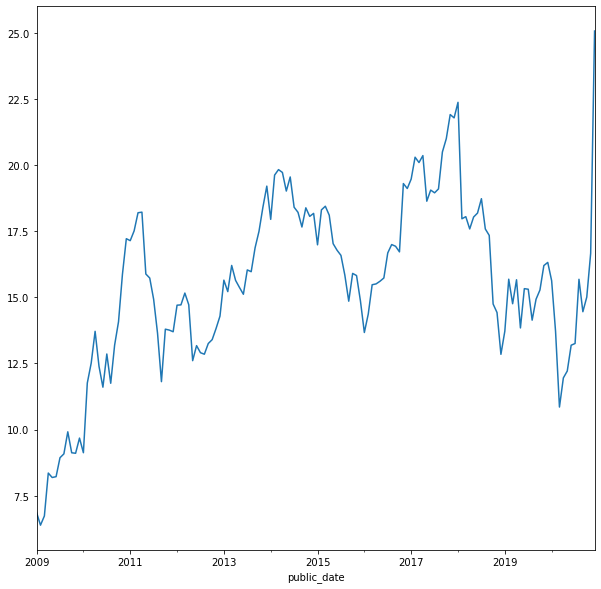

In [ ]:
industry = pd.read_csv('Financial_Ratios_Industry.csv')
industry['public_date'] = [datetime.datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d') for x in industry['public_date']]
industry['public_date'] = pd.to_datetime(industry['public_date'],errors='coerce')
industry['divyield_Median'] = industry['divyield_Median'].str.replace('%', '')
industry['divyield_Median']= industry['divyield_Median'].astype('float64')
industry = industry[industry['public_date']>'2009-01-01']
industry = industry.set_index('public_date')
industry[industry['gicdesc'] == 'Industrials']['pe_inc_Median'].plot(figsize = (10,10))
plt.show()

In [ ]:
company_ratio = pd.read_csv('Financial_Ratios_S&P.csv')
company_ratio['public_date'] = [datetime.datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d') 
                                for x in company_ratio['public_date']]
company_ratio['public_date'] = pd.to_datetime(company_ratio['public_date'],errors='coerce')
company_ratio = company_ratio[company_ratio['public_date']>'2009-01-01']
company_ratio = pd.merge(company_ratio, SP_500[['Symbol', 'GICS Sector']], left_on = 'TICKER',
                         right_on = 'Symbol').drop(['Symbol'], axis = 1)
company_ratio = company_ratio.set_index('public_date')
company_ratio.interpolate(method = 'time', inplace = True)


In [ ]:
company_fundamentals = pd.read_csv('SPY500_Fundamentals.csv')
company_fundamentals['public_date'] = [datetime.datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d') 
                                for x in company_fundamentals['datadate']]
company_fundamentals['public_date'] = company_fundamentals['public_date'].astype('datetime64[ns]')
tic = company_fundamentals['tic']
company_fundamentals= company_fundamentals.select_dtypes(exclude = ['object', 'int64'])
company_fundamentals['tic'] = tic
company_fundamentals

,fqtr,actq,chq,cogsq,dlttq,epsfiq,revtq,xoprq,public_date,tic
0,2.0,9072.0,287.0,5239.0,9331.0,-5.83,6179.0,5981.0,2008-06-30,AAL
1,3.0,7507.0,273.0,5525.0,9536.0,0.12,6421.0,6321.0,2008-09-30,AAL
2,4.0,5935.0,191.0,4503.0,9001.0,-1.24,5469.0,5255.0,2008-12-31,AAL
3,1.0,5362.0,187.0,4070.0,8842.0,-1.35,4839.0,4748.0,2009-03-31,AAL
4,2.0,5140.0,191.0,4140.0,8864.0,-1.39,4889.0,4740.0,2009-06-30,AAL
...,...,...,...,...,...,...,...,...,...,...
25374,1.0,922.0,245.3,361.6,1479.0,0.00,674.7,526.7,2020-03-31,ALLE
25375,2.0,977.1,302.4,320.7,1477.4,0.80,589.5,458.8,2020-06-30,ALLE
25376,3.0,1121.0,428.9,386.7,1497.2,1.58,728.4,538.9,2020-09-30,ALLE
25377,4.0,1145.0,480.4,385.9,1495.7,1.01,727.3,543.4,2020-12-31,ALLE


Text(0.5, 1.0, 'P/E vs. Price by Industry')

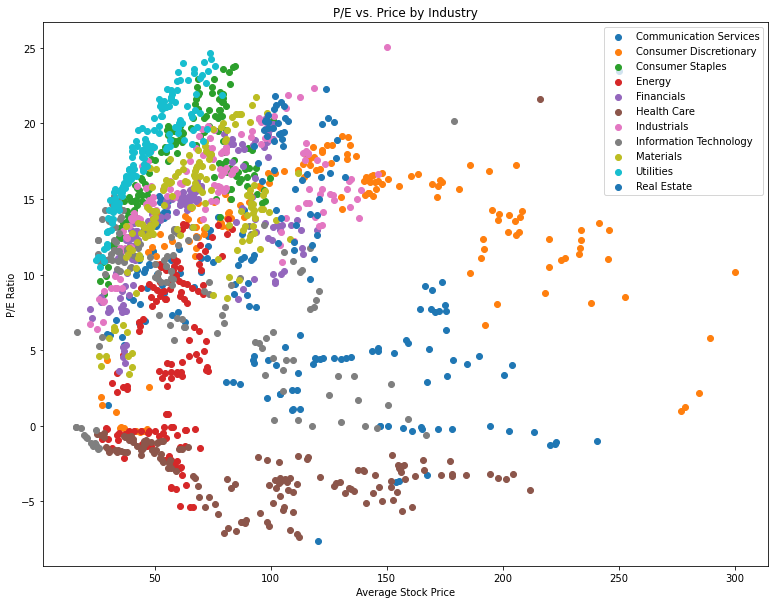

In [ ]:
sectors = industry['gicdesc'].unique()
corr_dict = {}
for val in sectors:
    industry_by_month = industry.loc[lambda industry: industry['gicdesc'] == val, :]
    stock_industry = stock.loc[lambda stock: stock['GICS Sector'] == val, :]
    stock_by_month = stock_industry.groupby(pd.Grouper(freq="M")).mean()
    stock_by_month = stock_by_month[stock_by_month.index.isin(industry_by_month.index)]
    corr_dict[val] = stock_by_month['HLOC'].corr(industry_by_month['pe_inc_Median'])
    fig = plt.gcf()
    fig.set_size_inches(13, 10)
    plt.scatter(stock_by_month['HLOC'], industry_by_month['pe_inc_Median'])
    plt.legend(sectors)
plt.xlabel('Average Stock Price')
plt.ylabel('P/E Ratio')
plt.title('P/E vs. Price by Industry')


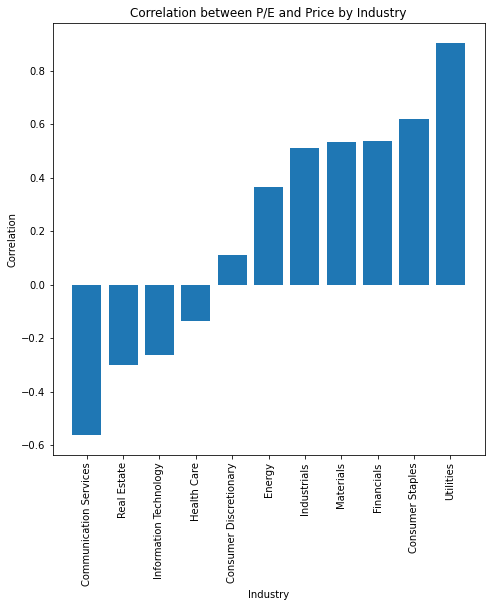

In [ ]:
bar = pd.DataFrame.from_dict(corr_dict, orient = 'index').sort_values(by = 0)

fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0,0,1,1])
langs = bar.index
ax.bar(langs,bar[0])
plt.xticks(rotation = 90)
plt.xlabel('Industry')
plt.ylabel('Correlation')
plt.title('Correlation between P/E and Price by Industry')
plt.show()

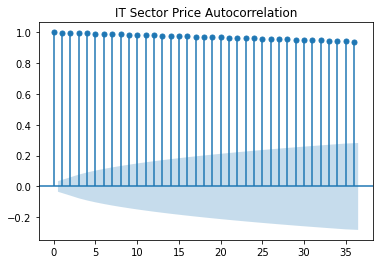

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(stock[stock['GICS Sector'] =='Information Technology'].groupby('Date').median()['HLOC'])
plt.title('IT Sector Price Autocorrelation')
plt.show()


In [ ]:
stock[stock['GICS Sector'] =='Health Care'].isna().sum()

Adj Close       0
Volume          0
Name            0
HLOC % Final    0
HLOC            0
GICS Sector     0
dtype: int64

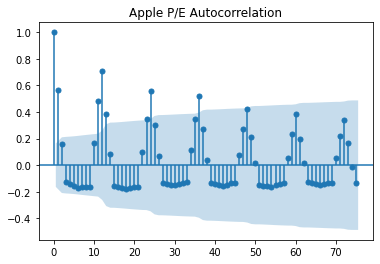

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(company_ratio[company_ratio['TICKER'] == 'AAPL']['pe_inc'], lags = 75)
plt.title('Apple P/E Autocorrelation')
plt.show()

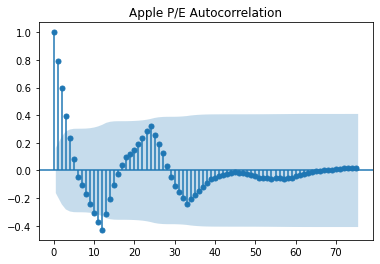

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(company_ratio[company_ratio['TICKER'] == 'AMZN']['pe_inc'], lags = 75)
plt.title('Apple P/E Autocorrelation')
plt.show()

In [ ]:
val = 'Industrials'
ratio_list = list(industry.columns)
ratio_list.remove('gicdesc')
ratio_list.remove('NFIRM')
correlation_dictionary = {}
for ratio in ratio_list:
    industry_by_month = industry.loc[lambda industry: industry['gicdesc'] == val, :]
    stock_industry = stock.loc[lambda stock: stock['GICS Sector'] == val, :]
    stock_by_month = stock_industry.groupby(pd.Grouper(freq="M")).mean()
    stock_by_month = stock_by_month[stock_by_month.index < datetime.datetime(2021,1,1)]
    correlation_dictionary[ratio] =  stock_by_month['HLOC'].corr(industry_by_month[ratio])
stock_by_month = stock_by_month[stock_by_month.index>'2009-01-01']

In [ ]:
stock_by_month.shift(1)

,Adj Close,Volume,HLOC % Final,HLOC
Date,,,,
2009-01-31,NaN,NaN,NaN,NaN
2009-02-28,21.726089,6.296664e+06,-0.004895,28.009391
2009-03-31,19.412167,8.000768e+06,-0.009518,25.163007
2009-04-30,17.372114,1.015184e+07,0.002940,22.321630
2009-05-31,20.573230,7.130633e+06,0.009533,26.223225
...,...,...,...,...
2020-08-31,120.935770,5.397502e+06,0.002611,122.180064
2020-09-30,131.718673,4.724690e+06,0.004128,132.818943
2020-10-31,132.962078,5.043080e+06,-0.000500,134.095956


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test =  train_test_split(np.array(industry_by_month.drop(['gicdesc'], axis = 1)), stock_by_month['HLOC'], random_state = 0)

regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(X_train,y_train )
from sklearn.metrics import mean_squared_error
mean_squared_error(regr.predict(X_test), y_test)

6.726136806550565

In [ ]:
correlation_df = pd.Series(correlation_dictionary, name = 'correlation')
correlation_df = pd.DataFrame(correlation_df)
correlation_df.sort_values(by = 'correlation', key=pd.Series.abs, ascending = False)

,correlation
lt_debt_Median,0.948109
de_ratio_Median,0.940359
capital_ratio_Median,0.940353
debt_invcap_Median,0.939090
equity_invcap_Median,-0.938948
...,...
intcov_Median,0.003969
indret_ew,-0.003586
rd_sale_Median,NaN
adv_sale_Median,NaN


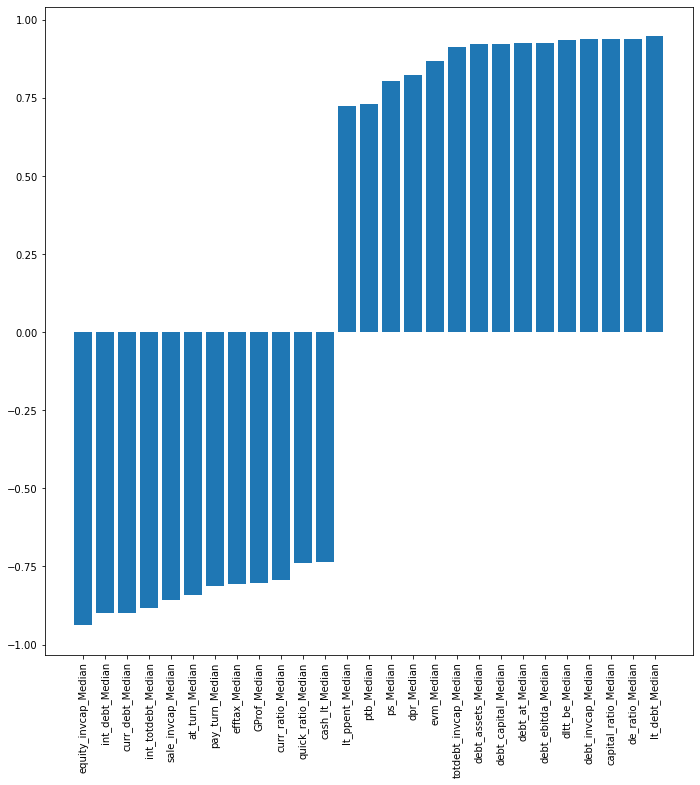

In [ ]:
bar = correlation_df[correlation_df['correlation'].abs()>0.7].sort_values(by = 'correlation')
fig = plt.figure(figsize = (9,9))
ax = fig.add_axes([0,0,1,1])
langs = bar.index
ax.bar(langs,bar['correlation'])
plt.xticks(rotation = 90)
plt.show()


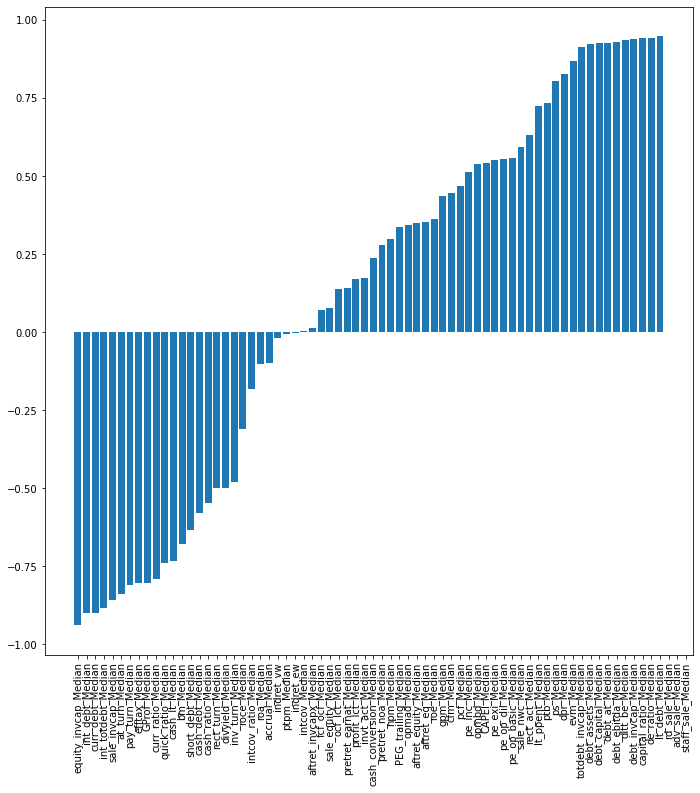

In [ ]:
bar = correlation_df.sort_values(by = 'correlation')
fig = plt.figure(figsize = (9,9))
ax = fig.add_axes([0,0,1,1])
langs = bar.index
ax.bar(langs,bar['correlation'])
plt.xticks(rotation = 90)
plt.show()

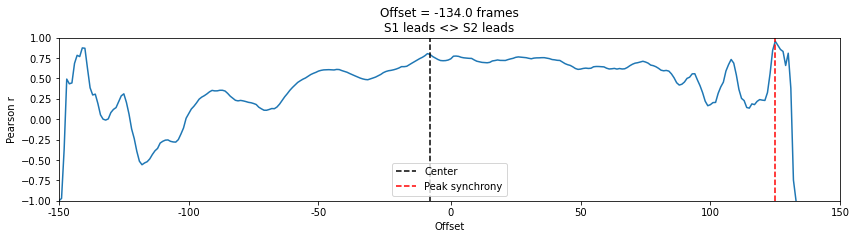

In [ ]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = stock_by_month['HLOC']
d2 = industry_by_month['ps_Median']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
rs = [x for x in rs if str(x) != 'nan']
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-1,1],xlim=[0,270], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()